Here's a notebook that walks through the process the `Blob_survey` class takes in constructing a list of observations to be executed. 

In [1]:
import numpy as np
import matplotlib.pylab as plt
import healpy as hp
from lsst.sims.featureScheduler.modelObservatory import Model_observatory
from lsst.sims.featureScheduler.schedulers import Core_scheduler
from lsst.sims.featureScheduler.utils import standard_goals, calc_norm_factor
import lsst.sims.featureScheduler.basis_functions as bf
from lsst.sims.featureScheduler.surveys import (generate_dd_surveys, Greedy_survey,
                                                Blob_survey)
from lsst.sims.featureScheduler import sim_runner

In [2]:
# Taking a large chunk of code from https://github.com/lsst-sims/sims_featureScheduler_runs/blob/master/baselines/baselines.py
# to setup a basic scheduler
def gen_greedy_surveys(nside, nexp=1):
    """
    Make a quick set of greedy surveys
    """
    target_map = standard_goals(nside=nside)
    norm_factor = calc_norm_factor(target_map)
    # Let's remove the bluer filters since this should only be near twilight
    filters = ['r', 'i', 'z', 'y']
    surveys = []

    for filtername in filters:
        bfs = []
        bfs.append(bf.M5_diff_basis_function(filtername=filtername, nside=nside))
        bfs.append(bf.Target_map_basis_function(filtername=filtername,
                                                target_map=target_map[filtername],
                                                out_of_bounds_val=np.nan, nside=nside,
                                                norm_factor=norm_factor))
        bfs.append(bf.Slewtime_basis_function(filtername=filtername, nside=nside))
        bfs.append(bf.Strict_filter_basis_function(filtername=filtername))
        # Masks, give these 0 weight
        bfs.append(bf.Zenith_shadow_mask_basis_function(nside=nside, shadow_minutes=60., max_alt=76.))
        bfs.append(bf.Moon_avoidance_basis_function(nside=nside, moon_distance=40.))
        bfs.append(bf.Clouded_out_basis_function())

        bfs.append(bf.Filter_loaded_basis_function(filternames=filtername))

        weights = np.array([3.0, 0.3, 3., 3., 0., 0., 0., 0.])
        surveys.append(Greedy_survey(bfs, weights, block_size=1, filtername=filtername,
                                     dither=True, nside=nside, ignore_obs='DD', nexp=nexp))

    return surveys


def generate_blobs(nside, mixed_pairs=False, nexp=1, no_pairs=False):
    target_map = standard_goals(nside=nside)
    norm_factor = calc_norm_factor(target_map)

    # List to hold all the surveys (for easy plotting later)
    surveys = []

    # Set up observations to be taken in blocks
    filter1s = ['u', 'g', 'r', 'i', 'z', 'y']
    if mixed_pairs:
        filter2s = [None, 'r', 'i', 'z', None, None]
    else:
        filter2s = [None, 'g', 'r', 'i', None, None]

    if no_pairs:
        filter2s = [None, None, None, None, None, None]

    # Ideal time between taking pairs
    pair_time = 22.
    times_needed = [pair_time, pair_time*2]
    for filtername, filtername2 in zip(filter1s, filter2s):
        bfs = []
        bfs.append(bf.M5_diff_basis_function(filtername=filtername, nside=nside))
        if filtername2 is not None:
            bfs.append(bf.M5_diff_basis_function(filtername=filtername2, nside=nside))
        bfs.append(bf.Target_map_basis_function(filtername=filtername,
                                                target_map=target_map[filtername],
                                                out_of_bounds_val=np.nan, nside=nside,
                                                norm_factor=norm_factor))
        if filtername2 is not None:
            bfs.append(bf.Target_map_basis_function(filtername=filtername2,
                                                    target_map=target_map[filtername2],
                                                    out_of_bounds_val=np.nan, nside=nside,
                                                    norm_factor=norm_factor))
        bfs.append(bf.Slewtime_basis_function(filtername=filtername, nside=nside))
        bfs.append(bf.Strict_filter_basis_function(filtername=filtername))
        # Masks, give these 0 weight
        bfs.append(bf.Zenith_shadow_mask_basis_function(nside=nside, shadow_minutes=60., max_alt=76.))
        bfs.append(bf.Moon_avoidance_basis_function(nside=nside, moon_distance=30.))
        bfs.append(bf.Clouded_out_basis_function())
        filternames = [fn for fn in [filtername, filtername2] if fn is not None]
        bfs.append(bf.Filter_loaded_basis_function(filternames=filternames))
        if filtername2 is None:
            time_needed = times_needed[0]
        else:
            time_needed = times_needed[1]
        bfs.append(bf.Time_to_twilight_basis_function(time_needed=time_needed))
        bfs.append(bf.Not_twilight_basis_function())
        weights = np.array([3.0, 3.0, .3, .3, 3., 3., 0., 0., 0., 0., 0., 0.])
        if filtername2 is None:
            # Need to scale weights up so filter balancing still works properly.
            weights = np.array([6.0, 0.6, 3., 3., 0., 0., 0., 0., 0., 0.])
        if filtername2 is None:
            survey_name = 'blob, %s' % filtername
        else:
            survey_name = 'blob, %s%s' % (filtername, filtername2)
        surveys.append(Blob_survey(bfs, weights, filtername1=filtername, filtername2=filtername2,
                                   ideal_pair_time=pair_time, nside=nside,
                                   survey_note=survey_name, ignore_obs='DD', dither=True,
                                   nexp=nexp))

    return surveys


In [3]:
# Construct the surveys we want to run
nside=32
nexp=1
# Simple greedy survey as option of last resort in twilight
greedy = gen_greedy_surveys(nside, nexp=nexp)
# Deep Drilling Fields
ddfs = generate_dd_surveys(nside=nside, nexp=nexp)
# Blobs that take pairs in mixed filters
blobs = generate_blobs(nside, nexp=nexp, mixed_pairs=True)

surveys = [ddfs, blobs, greedy]

In [4]:
n_visit_limit = 35774  # Set a limit so we stop at a point where a blob r+i is about to execute
scheduler = Core_scheduler(surveys, nside=nside)
observatory = Model_observatory(nside=nside)
observatory, scheduler, observations = sim_runner(observatory, scheduler,
                                                      survey_length=365.25*10,
                                                      filename='blob_explained',
                                                      delete_past=True, n_visit_limit=n_visit_limit,
                                                      verbose=True)

/Users/yoachim/gitRepos/sims_skybrightness_pre/python/lsst/sims/skybrightness_pre/SkyModelPre.py:377: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn('Requested MJD between sunrise and sunset, returning closest maps')
/Users/yoachim/gitRepos/sims_featureScheduler/python/lsst/sims/featureScheduler/modelObservatory/model_observatory.py:476: RuntimeWarning: invalid value encountered in less
  slewtimes[np.where(slewtimes < 0)] = np.nan


progress = 1.13%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 35774 observations
ran in 6 min = 0.1 hours


Vocabulary

We are using a slightly modified Markov Decision Process (MDP) to generate lists of observations. 

The first step in a MDP is computing/gathering features. In this context, a **feature** is something that either describes the current conditions, or the progress of the survey to date. Some example features include:

* The current date
* What filters are loaded in the telescope
* A sky map showing how many observations have been completed in r-band.
* The current atmospheric seeing (or a set of maps showing the expected seeing across the sky and in each filter)

Note that features are very general, they can be floats, ints, strings, arrays, lists, etc. For our purposes, we have divided features into those that track the progress of the survey and current conditions that come in as telemetry from the observatory. This is an implementation convienence, mathmatically they are still all "features" for the MDP. 

Once we have all the relevant features computed, we construct **basis functions**. We have implamented basis functions as python objects which take in completed observation metadata (e.g., RA, dec, filter, seeing, airmass, etc for each completed observation) as well as the current conditions. Most basis functions also take additional information as kwargs on instatiation, for example, a HEALpix map of the desired survey footprint. Basis functions then output either a HEALpix map or single float value. The output of a basis function is unitless, and typically we try to normalize the basis functions so that values are of order unity. Positive values are areas of the sky that are more desireable, while negative values are less desireable. 

There are several basis functions we almost always use:

`Target_map_basis_function`:  This basis function tracks how many observations have been taken at each point on the sky (i.e., at the centers of HEALpixels) and compares it to the desired survey footprint. HEALpixels which have fallen behind the overall survey are given higher values, while pixels that have been observed more are given negative values. 

`M5_diff_basis_function`: This basis function first computes the 5-sigma point source limiting depth across the sky. The 5-sigma limiting depth is a function of skybrightess, seeing, and airmass.  It then takes a difference with a map (computed at instatiation) of what the 5-sigma depth of each point is when it is in dark time, on the meridian, and in "good" seeing conditions. Conceptually, this basis function is telling us the penalty (in magnitudes) of observing a point in the sky now versus waiting for ideal conditions. Thus, in dark time all filters will have equal reward on the meridian, but the u-band reward will drop off more sharply with airmass than the z-band. In bright time, the reward will go negative for all filters, but more negative in bluer filters than redder filters. 

`Slewtime_basis_function`: Generated from the observatory model, a map of how long it would take to slew to any particular spot on the sky. The slew time map is multiplied by negative one and normalized by two minutes so longer slews are penalized.

We also make use of several basis functions that work as masks (values are only zero on NaN). For example, we mask the sky at zenith and include a mask around the moon. 

Once all the basis functions are calculated, the **reward function** is calculated. The reward function is a linear combination of the basis functions. The weights given to each basis function are the free parameters of the scheduler. The basis function weights can be thought of as converting all of our typical observing desires to similar units. The basis function weights determine how many magnitudes of extra depth we are willing to go after in exchange for X more seconds of slew time. Or, how much depth will we sacrifice to restore survey uniformity. One major advantage of the MDP is that we can achieve good performance with only a few (well chosen) basis functions, thus optimizing the performance of the scheduler is done over a small number of dimensions. Because we have a 6-filter survey, we compute a reward function for each filter. Whichever filter has the highest maximum reward value is selected as the winner.

Once the reward function is calculated, the final step in the MDP is to pass the reward function to the **decision function**. In our implementation, we have `survey` objects which compute the reward function with a `calc_reward_function` method, and have the decision function as the `generate_observations` method. As you might guess, the decision function uses the reward function to generate a list of observations to be observed. 

Some important points:

* There is currently little-to-no looking into the future. We check if there is enough time before twilight to complete a blob, but other than that the decision process is not using the future. We can incorporate basis functions that have information about the future (e.g., how many nights a spot will be visible in the current season), but currently there doesn't seem to be a compelling rea
* The blob decision function is taking advantage of the fact that the reward function is typically fairly smooth and fairly stable on ~40 minute timescales. 
* There is no master list of observations to be executed. This mean the scheduler does not know anything about SRD values. Rather, we train the scheduler such that, given enough time, it will reach the SRD goals.
* There are no fixed survey fields. We do not have a fixed list of fields, rather, we track progress on a HEALpix map that is computed at higher resolution than an LSST field of view. (OK, the Deep Drilling Fields are fixed, but they can be set to any arbitrary position)
* In the baseline scheduler, there is no explicit driving of survey cadence.
* We have avoided using explicit seeing or sky brighntess limits. 
* There are no proposals. The differences between the WFD area and other regions like the Galactic Plane and South Celestial Pole are reflected in the survey footprint. Other than the number of observations, all wide area regions of the sky are observed in a similar fashion. 


In [6]:
conditions = observatory.conditions

In [13]:
# Let's look at the survey objects we have
scheduler.survey_lists


[[<lsst.sims.featureScheduler.surveys.dd_surveys.Deep_drilling_survey at 0x131d9aefd0>,

In [14]:
# What is the reward for all the DDFs?
ddf_reward = [survey.calc_reward_function(conditions) for survey in scheduler.survey_lists[0]]
print('ddf reward values=', ddf_reward)

ddf reward values= [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf]


In [16]:
# OK, none of the DDFs want to execute right now, let's check the blobs. These are returning HEALpix arrays
blob_rewards = [np.nanmax(survey.calc_reward_function(conditions)) for survey in scheduler.survey_lists[1]]
print('blob rewards=', blob_rewards)

blob rewards= [-inf, 4.5602594825937643, 2.6411475770070991, 1.6788998202689318, 1.7410710649450525, -0.40633823178509632]


/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


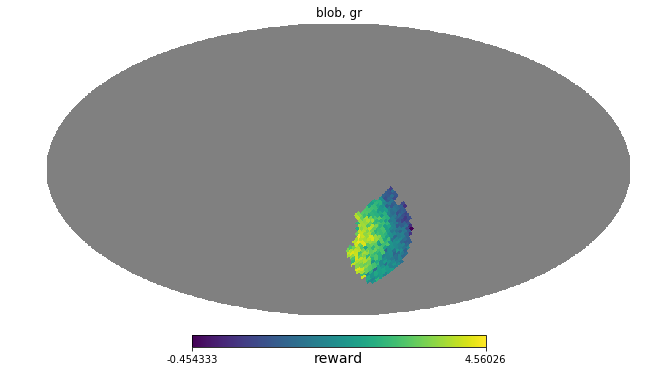

In [20]:
# The u-band isn't loaded, so the u-band blob returns -inf. and we can see the second survey is the max.
# What does that full reward look like?
hp.mollview(scheduler.survey_lists[1][1].calc_reward_function(conditions), unit='reward', title=scheduler.survey_lists[1][1].survey_note)

/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


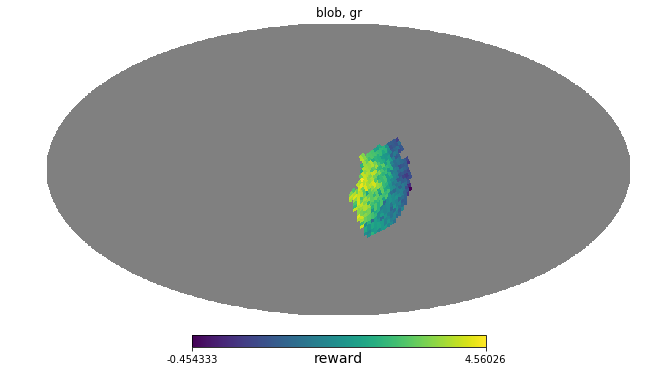

In [21]:
# We can rotate this so zenith is at the center of the projection
rot = (conditions.lmst*180./12., conditions.site.latitude)
hp.mollview(scheduler.survey_lists[1][1].calc_reward_function(conditions), unit='reward',
            title=scheduler.survey_lists[1][1].survey_note, rot=rot)

/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


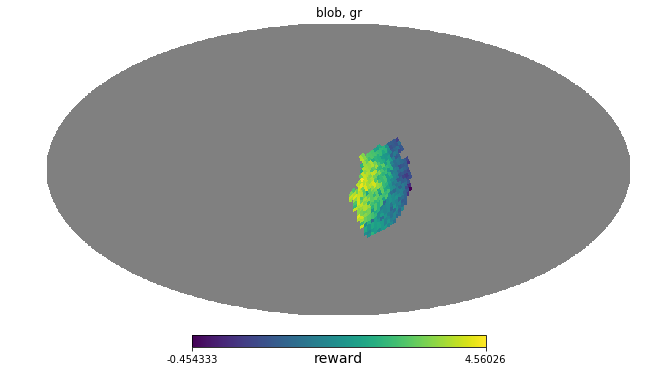

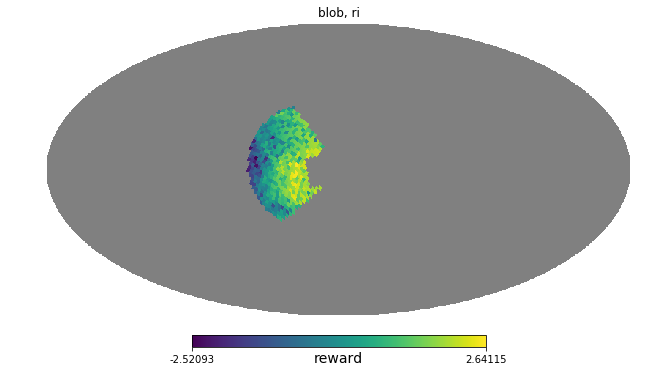

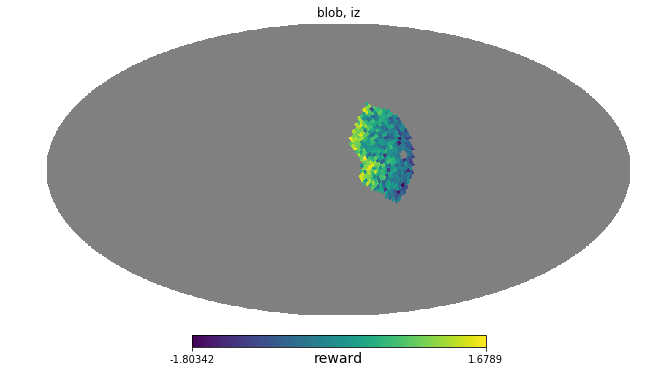

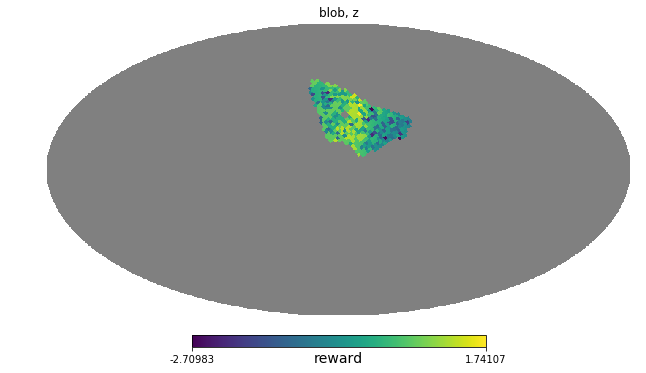

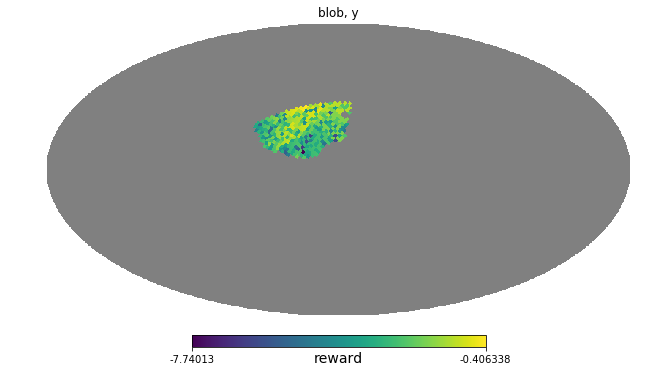

In [26]:
# We can look at all the reward functions
for i in range(len(scheduler.survey_lists[1])):
    reward_val = scheduler.survey_lists[1][i].calc_reward_function(conditions)
    if np.size(reward_val) > 1:
        hp.mollview(reward_val, unit='reward',
                    title=scheduler.survey_lists[1][i].survey_note, rot=rot)